In [1]:
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util

In [2]:
np.random.seed(41)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


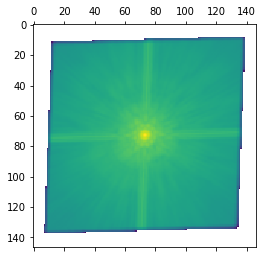

In [3]:
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Users\ZN\Desktop\lenstronomy\psf_example.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

In [4]:
# data specifics
background_rms = 0  #  background noise per pixel (Gaussian rms value)
exp_time = np.inf  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 30  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91  # PSF kernel size (odd number required).

In [5]:
# initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)


# lensing quantities
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_pemd = {'theta_E': 0.45, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model
kwargs_nfw = {'alpha_Rs': 0.02, 'Rs': 0.1, 'center_x': 1., 'center_y': 1}
# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['EPL', 'SHEAR', 'NFW']
kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_x = 0
source_y = 0

# Sersic parameters in the initial simulation
phi_G, q = 0.5, 0.8
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
#kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)

# lens light model
phi_G, q = 0.9, 0.9
e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
kwargs_sersic_lens = {'amp': 1000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock

kwargs_data['image_data'] = image_sim
data_class.update_data(image_sim)

C:\Users\ZN\AppData\Roaming\Python\Python37\site-packages\lenstronomy\Data\image_noise.py:42: RuntimeWarning: invalid value encountered in double_scalars
  if background_rms * np.max(exposure_time) < 1 and verbose is True:


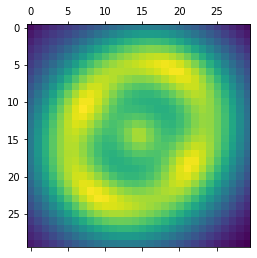

In [6]:
plt.matshow(np.log10(image_sim))

## Construct a random covariance matrix (avoiding a very large eigenvalue)

In [57]:
D_diag=np.abs(np.random.randn(900)+1)*4

In [58]:
D=np.diag(D_diag)

In [59]:
np.shape(D_diag)

(900,)

In [60]:
D_diag

array([6.09764230e+00, 5.89637283e+00, 5.89390845e+00, 1.82463620e+00,
       6.23663907e-01, 1.67427354e+00, 2.26739040e+00, 6.72820763e+00,
       7.31742223e-01, 6.61078913e+00, 9.56850714e+00, 1.80044537e+00,
       6.00907016e-01, 1.90421415e+00, 2.92910275e+00, 7.62341381e+00,
       1.74742830e+00, 5.38400203e+00, 1.08778732e+01, 3.83582014e-01,
       3.71345203e+00, 4.22344683e+00, 7.35106474e+00, 9.66342222e+00,
       8.30119761e+00, 5.66640836e-01, 5.50596068e+00, 7.48940700e+00,
       1.26079197e+00, 4.44591446e-01, 7.06628048e+00, 2.27114914e+00,
       4.98195239e+00, 3.25719050e+00, 9.51972686e+00, 5.87431577e+00,
       7.22523015e+00, 2.27188370e+00, 3.77830853e+00, 4.33528579e+00,
       8.18608450e+00, 4.59915366e+00, 1.28921629e-01, 9.62930450e+00,
       1.05556548e+01, 1.71850530e+00, 1.10401431e+00, 5.84500420e+00,
       8.93354055e+00, 7.99055560e+00, 1.02490495e+00, 1.58409043e+00,
       1.24526097e+01, 9.16299330e+00, 9.81834382e-01, 2.35509512e-01,
      

In [62]:
np.shape(D)

(900, 900)

In [63]:
D

array([[6.0976423 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 5.89637283, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 5.89390845, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 4.72840531, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 4.43057608,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        8.26082029]])

In [64]:
D_map=util.array2image(D_diag)

In [65]:
np.shape(D_map)

(30, 30)

In [66]:
from scipy.stats import ortho_group

In [67]:
P=ortho_group.rvs(900)

In [68]:
np.matmul(P,P.T)

array([[ 1.00000000e+00,  5.20417043e-17, -4.27175656e-17, ...,
        -2.77555756e-17,  4.68375339e-17, -7.11236625e-17],
       [ 5.20417043e-17,  1.00000000e+00,  1.38777878e-16, ...,
         1.34441069e-17, -2.14672030e-17,  2.08166817e-17],
       [-4.27175656e-17,  1.38777878e-16,  1.00000000e+00, ...,
         8.02309608e-18, -2.25514052e-17, -1.04083409e-17],
       ...,
       [-2.77555756e-17,  1.34441069e-17,  8.02309608e-18, ...,
         1.00000000e+00, -2.25514052e-17, -2.51534904e-17],
       [ 4.68375339e-17, -2.14672030e-17, -2.25514052e-17, ...,
        -2.25514052e-17,  1.00000000e+00,  3.38271078e-17],
       [-7.11236625e-17,  2.08166817e-17, -1.04083409e-17, ...,
        -2.51534904e-17,  3.38271078e-17,  1.00000000e+00]])

In [69]:
np.sum(np.matmul(P,P.T))

900.0

In [70]:
a=np.matmul(P,D)
M=np.matmul(a,P.T)

In [71]:
M

array([[ 4.79226351,  0.06269334,  0.00804151, ..., -0.04734262,
        -0.02462674, -0.09036757],
       [ 0.06269334,  4.80292233,  0.06234121, ..., -0.13742087,
         0.13294322,  0.03885053],
       [ 0.00804151,  0.06234121,  4.68443165, ...,  0.0078768 ,
        -0.00553723,  0.04303847],
       ...,
       [-0.04734262, -0.13742087,  0.0078768 , ...,  4.6258117 ,
         0.05523134,  0.08471492],
       [-0.02462674,  0.13294322, -0.00553723, ...,  0.05523134,
         5.02977779, -0.02352999],
       [-0.09036757,  0.03885053,  0.04303847, ...,  0.08471492,
        -0.02352999,  4.4468808 ]])

In [72]:
testTEigen,testP=np.linalg.eig(M)

In [73]:
testTEigen

array([1.61914731e+01, 1.55939350e+01, 1.55066470e+01, 1.54607200e+01,
       1.44180623e+01, 1.42836591e+01, 1.40782912e+01, 1.40513987e+01,
       1.34717472e+01, 1.31280315e+01, 1.27600873e+01, 1.23806268e+01,
       1.24526097e+01, 1.24519979e+01, 1.24286934e+01, 1.24320425e+01,
       1.20561661e+01, 1.20029566e+01, 1.19770651e+01, 1.18767291e+01,
       1.17065234e+01, 1.16320580e+01, 1.16111219e+01, 1.15810839e+01,
       1.13893865e+01, 1.13810114e+01, 1.13225165e+01, 1.12939291e+01,
       1.12427288e+01, 1.12350009e+01, 1.12101813e+01, 1.12032911e+01,
       1.11859887e+01, 1.11068905e+01, 1.11042402e+01, 1.10086444e+01,
       1.08778732e+01, 1.07530291e+01, 1.07202955e+01, 1.05556548e+01,
       1.04891822e+01, 1.04438873e+01, 1.04266088e+01, 1.02958360e+01,
       1.02823117e+01, 1.01216875e+01, 1.02074559e+01, 1.01457969e+01,
       1.01464577e+01, 1.01952925e+01, 1.01872673e+01, 1.01795820e+01,
       1.01740171e+01, 7.14355850e-04, 6.41778966e-02, 5.22235421e-02,
      

In [74]:
np.max(D_diag)

16.191473113784006

In [75]:
np.max(testTEigen)

16.191473113784035

- M,P,D are the matrices we have constructed.

## Add the correlated noise, constructing the noisy data image.

In [76]:
data_lin=util.image2array(image_sim)

In [77]:
data_lin_transed=np.matmul(P.T,data_lin)

In [78]:
the_noise=np.random.randn(900)*np.sqrt(D_diag)

In [79]:
data_noisy_lin_transed=data_lin_transed+the_noise

In [80]:
data_noisy_lin=np.matmul(P,data_noisy_lin_transed)

In [81]:
data_noisy=util.array2image(data_noisy_lin)

In [82]:
data_noisy_transed=util.array2image(data_noisy_lin_transed)

In [83]:
data_class.update_data(data_noisy_transed)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


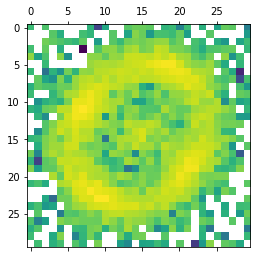

In [84]:
plt.matshow(np.log10(data_noisy))

## Calculate the likelihood.

In [85]:
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data,noise_map=np.sqrt(D_map))### put the variance matrix in the diagonalized basis here
data_class.update_data(data_noisy_transed)

In [86]:
mask=np.ones(np.shape(data_class.data))

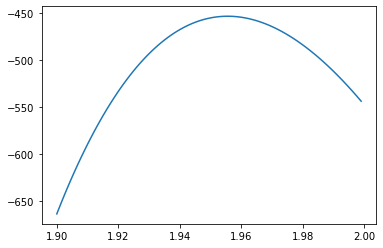

In [87]:
N_number=100
log_likelihood_list=np.zeros(N_number)
theta_E_list=np.zeros(N_number)
for i in range(N_number):
    theta_E=0.001*(i+1900)
    kwargs_pemd = {'theta_E': 0.45, 'gamma':theta_E, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}
    kwargs_lens = [kwargs_pemd, kwargs_shear, kwargs_nfw]
    model_vary = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)
    model_vary_lin=util.image2array(model_vary)
    model_vary_lin_transed=np.matmul(P.T,model_vary_lin)
    model_vary_transed=util.array2image(model_vary_lin_transed)
    theta_E_list[i]=theta_E
    log_likelihood_list[i]=data_class.log_likelihood(model_vary_transed,mask)
    if i==45:
        model45_transed=model_vary_transed

plt.plot(theta_E_list,log_likelihood_list)

In [89]:
theta_E_list[56]

1.956

In [45]:
log_likelihood_list[45]

-454.46963616527717

In [88]:
np.argmax(log_likelihood_list)

56

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


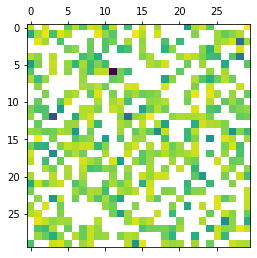

In [264]:
plt.matshow(np.log10(data_class.data))

In [47]:
model45_transed_lin=util.image2array(model45_transed)

In [48]:
model45_lin=np.matmul(P,model45_transed_lin)

In [49]:
model45=util.array2image(model45_lin)

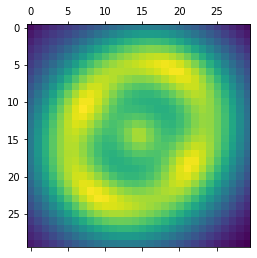

In [50]:
plt.matshow(np.log10(util.array2image(model45_lin)))

In [51]:
delta=model45_lin-data_noisy_lin
a=np.matmul(delta.T,np.linalg.inv(M))
np.matmul(a,delta)

908.9392723305518

In [270]:
np.shape(Minv)

(900, 900)

In [271]:
data_class.log_likelihood(model45_transed,mask)

-436.08343409384395

In [240]:
M

array([[ 0.46336143,  0.00404524,  0.00731291, ...,  0.00863421,
        -0.01745468,  0.01955434],
       [ 0.00404524,  0.47339706,  0.00274814, ..., -0.00561317,
        -0.00197332,  0.01185773],
       [ 0.00731291,  0.00274814,  0.45307923, ..., -0.00480282,
         0.00557807, -0.002004  ],
       ...,
       [ 0.00863421, -0.00561317, -0.00480282, ...,  0.49876067,
        -0.01154462, -0.02116237],
       [-0.01745468, -0.00197332,  0.00557807, ..., -0.01154462,
         0.46675873,  0.02095792],
       [ 0.01955434,  0.01185773, -0.002004  , ..., -0.02116237,
         0.02095792,  0.44462104]])